# Neural Network SMS Text Classifier

This is my solution for the Neural Network SMS Text Classifier project from FreeCodeCamp. Instructions for this project can be found [here](https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/neural-network-sms-text-classifier).

## Introduction
For this project, I am going to use PyTorch instead of TensorFlow.
The reason is that it's more relevant for me to learn.
Learning a new framework is challenging enough on its own, so to simplify the task, the Recurrent Neural Network (RNN) model with LSTM unit will be used.

Although the data has already been prepared for us, we will begin with a bit of EDA (Explorary Data Analysis). Then, we set up the necessary components: a tokenizer, data preprocessing steps, and the LSTM-based model. Our approach includes employing cross-validation to optimize hyperparameters for effective training.

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-08-19 06:56:28--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.02s   

2023-08-19 06:56:29 (17.1 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-08-19 06:56:29--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
# Load the training dataset
train_df = pd.read_table(train_file_path, names=['label', 'text'])
train_df.head()

,label,text
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
# We need to know how well the dataset is balanced
train_df['label'].value_counts()

ham     3619
spam     560
Name: label, dtype: int64

Text(0.5, 1.0, 'Number of labeled messages')

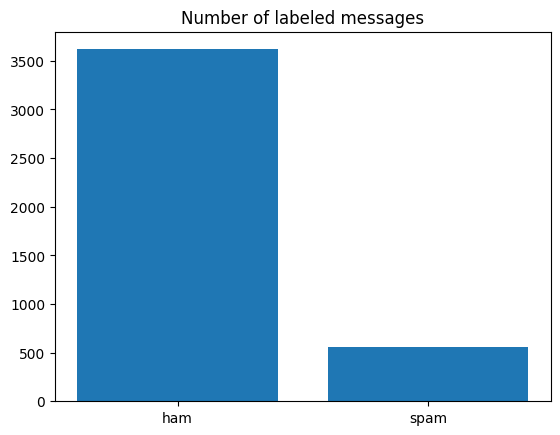

In [ ]:
# It looks like we have quite unbalanced dataset
count = train_df['label'].value_counts()
plt.bar(count.index, count )
plt.title('Number of labeled messages')

In [ ]:
# Load testing dataset
test_df = pd.read_table(test_file_path, names=['label', 'text'])
test_df['label'].value_counts()

ham     1205
spam     187
Name: label, dtype: int64

In [ ]:
# Define the tokenizer
def get_tokens(data):
    for text in data:
        yield tokenizer(text)
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Build the vocabulary
vocab = build_vocab_from_iterator(get_tokens(train_df['text']), specials=['<unk>'], min_freq=2)
vocab.set_default_index(vocab['<unk>'])
vocab_size = len(vocab)

# Calculate max sequence length
max_sequence_len = train_df['text'].apply( lambda x: len( tokenizer(x) ) ).max()

# Check tokenizer
with torch.no_grad():
    text = train_df.loc[0, 'text']
    tokens = tokenizer(text)
    print('Tokens: ', tokens)
    print('Vocabulary size: ', vocab_size)

Tokens:  ['ahhhh', '...', 'just', 'woken', 'up!had', 'a', 'bad', 'dream', 'about', 'u', 'tho', ',', 'so', 'i', 'do', 'nt', 'like', 'u', 'right', 'now', ':)', 'i', 'did', 'nt', 'know', 'anything', 'about', 'comedy', 'night', 'but', 'i', 'guess', 'i', 'm', 'up', 'for', 'it', '.']
Vocabulary size:  3623


In [ ]:
# Define our Dataset class
class SMSDataset(Dataset):
    def __init__(self, file_path, tokenizer, vocab):
        self.data = []
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                label, text = line.strip().split('\t')
                self.data.append((label, text))
        self.tokenizer = tokenizer
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label, text = self.data[index]
        encoded_label = 1 if label == 'spam' else 0
        tokens = self.tokenizer(text)
        numerical_tokens = [self.vocab[token] for token in tokens]

        return torch.tensor(numerical_tokens), torch.tensor(encoded_label)

    # to ensure that all batches have the same size
    def collate_fn(self, batch):
        data, labels = zip(*batch)

        # Pad data and labels to the same length
        padded_data = pad_sequence(data, batch_first=True)
        padded_labels = torch.tensor(labels)

        return padded_data, padded_labels

# Create our training and testing datasets
train_data = SMSDataset(train_file_path, tokenizer, vocab)
test_data = SMSDataset(test_file_path, tokenizer, vocab)

# Check sampling and batching. Make sure that all batches have the same size
with torch.no_grad():
    batch_size = 64
    data, label = train_data[0]
    print("Sample Data:", data)
    print("Sample Label:", label)
    data_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=train_data.collate_fn)
    for data, labels in data_loader:
        print('Data Shape:', data.shape)
        #print('Data Items Shape:', [data.shape for data in data])
        print("Labels Shape:", labels.shape)

Sample Data: tensor([   0,   10,   47, 3589,    0,    7,  427,  826,   95,   11,  864,    5,
          34,    2,   20,   52,   71,   11,  183,   30,  110,    2,   89,   52,
          69,  187,   95, 1662,  130,   33,    2,  332,    2,  155,   55,   18,
          17,    1])
Sample Label: tensor(0)
Data Shape: torch.Size([64, 70])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 42])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 42])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 68])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 40])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 41])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 175])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 43])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 146])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 166])
Labels Shape: torch.Size([64])
Data Shape: torch.Size([64, 47])
Labels Shape: torch.Size([

In [ ]:
# For simplicity, let's use an LSTM-based model
class TextClassifier(nn.Module):
    def __init__(self, vocab_size,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True
                           )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, text):
        embedded = self.dropout( self.embedding(text) )
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# Initializer the model
model = TextClassifier( vocab_size,
                       embedding_dim=100,
                       hidden_dim=256,
                       output_dim=1,
                       n_layers=2,
                       bidirectional=True
                      )
# Check model summary
print(model)

# Set the model to evaluation mode
model.eval()

# Make sure that the model output and labels have the same shape and datatypes
with torch.no_grad():
    batch_size = 64
    data_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=train_data.collate_fn)
    data, labels = next(iter(data_loader))
    predictions = model(data).squeeze(1)
    labels = labels.float()
    print("Predictions Shapes:", predictions.shape, "Labels:", labels.shape)
    print("Predictions DataTypes:", predictions.dtype, "Labels:", labels.dtype)

TextClassifier(
  (embedding): Embedding(3623, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Predictions Shapes: torch.Size([64]) Labels: torch.Size([64])
Predictions DataTypes: torch.float32 Labels: torch.float32


In [ ]:
# Prepare the model for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define hyperparameters
num_folds = 5
num_epochs = 5
batch_size = 128
learn_rate = 0.001
weight_decay = 0

# Calculate imbalance ratios between "ham" and spam
ham_count, spam_count = train_df['label'].value_counts()
spam_ratio = spam_count / ham_count
ham_ratio = ham_count / spam_count

# Define class weights. We do it because we have quite unbalanced dataset
class_weights = torch.tensor(1.0/ spam_ratio).to(device)

# Define the loss function
loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Check that everything is set
print("Device:", device)
print("Class weights:", class_weights)

# Make sure that our loss function works well
with torch.no_grad():
    model.eval() # Set the model to evaluation mode
    batch_size = 64
    data_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=train_data.collate_fn)
    total_loss = 0.0
    for _ in range(5):
        data, labels = next( iter(data_loader) )
        data, labels = data.to(device), labels.to(device)
        predictions = model(data)
        total_loss += loss_function(predictions.squeeze(), labels.float()).item()
    average_loss = total_loss / len(data_loader)
    print(f'Average Loss: {average_loss:.4f}')

Device: cpu
Class weights: tensor(6.4625)
Average Loss: 0.0973


In [ ]:
def train_one_epoch(model, dataloader, optimizer, loss_function, device):
    model.train()
    total_loss = 0.0
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(data)
        batch_loss = loss_function(predictions.squeeze(1), labels.float())
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            predictions = model(data)
            total_loss += loss_function(predictions.squeeze(1), labels.float()).item()
    return total_loss / len(dataloader)

# Cross-validation loop
for fold, (train_indices, val_indices) in enumerate( kf.split(range(len(train_data))) ):
    train_data_fold = Subset(train_data, train_indices)
    val_data_fold = Subset(train_data, val_indices)

    train_loader_fold = DataLoader(train_data_fold,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       collate_fn=train_data.collate_fn)
    val_loader_fold = DataLoader(val_data_fold,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     collate_fn=train_data.collate_fn)

    # Initialize optimizer
    optimizer = optim.Adam( model.parameters(), lr=learn_rate, weight_decay=weight_decay)

    # Training loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model,
                                     train_loader_fold,
                                     optimizer,
                                     loss_function,
                                     device)
        val_loss = validate(model,
                            val_loader_fold,
                            loss_function,
                            device)
        print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}],',
              f'Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Fold 1, Epoch [1/5], Train Loss: 0.7363, Validation Loss: 0.4175
Fold 1, Epoch [2/5], Train Loss: 0.3784, Validation Loss: 0.3626
Fold 1, Epoch [3/5], Train Loss: 0.2991, Validation Loss: 0.3653
Fold 1, Epoch [4/5], Train Loss: 0.2267, Validation Loss: 0.3707
Fold 1, Epoch [5/5], Train Loss: 0.1968, Validation Loss: 0.2911
Fold 2, Epoch [1/5], Train Loss: 0.1958, Validation Loss: 0.1038
Fold 2, Epoch [2/5], Train Loss: 0.1499, Validation Loss: 0.0871
Fold 2, Epoch [3/5], Train Loss: 0.1285, Validation Loss: 0.0811
Fold 2, Epoch [4/5], Train Loss: 0.0930, Validation Loss: 0.1458
Fold 2, Epoch [5/5], Train Loss: 0.0983, Validation Loss: 0.1093
Fold 3, Epoch [1/5], Train Loss: 0.1508, Validation Loss: 0.0373
Fold 3, Epoch [2/5], Train Loss: 0.0771, Validation Loss: 0.0464
Fold 3, Epoch [3/5], Train Loss: 0.0691, Validation Loss: 0.0540
Fold 3, Epoch [4/5], Train Loss: 0.0409, Validation Loss: 0.0461
Fold 3, Epoch [5/5], Train Loss: 0.0424, Validation Loss: 0.0577
Fold 4, Epoch [1/5], Trai

In [ ]:
# Test the model
test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn=test_data.collate_fn)
model.eval()
with torch.no_grad():
    true_labels = np.array([])
    pred_labels = np.array([])

    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        predictions = model(data).squeeze(1)
        rounded_preds = torch.round( torch.sigmoid(predictions) )
        true_labels = np.concatenate(( true_labels, labels.cpu().numpy() ))
        pred_labels = np.concatenate(( pred_labels, rounded_preds.cpu().numpy() ))

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precission: {precision: .4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

Accuracy: 0.9763
Precission:  0.8812
Recall: 0.9519
F1-score: 0.9152


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    model.eval()

    # Tokenize the input text
    tokens = tokenizer(pred_text)
    numerical_tokens = [vocab[token] for token in tokens]

    # Convert to a tensor and make a prediction
    data = torch.tensor([numerical_tokens]).to(device)
    with torch.no_grad():
        prediction = torch.sigmoid(model(data)).item()
    # Determine the label based on the prediction
    label = 'spam' if prediction >= 0.5 else 'ham'

    return [prediction, label]


pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.018541013821959496, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
